In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Tensorflow-Models

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1oP3ewZgiatY88SU5esvVcTCqbdfjYu1d/Tensorflow-Models


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import Sequence
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import os, cv2
import copy
import pandas as pd

# Patch for numpy.bool deprecation in imgaug
# imgaug uses np.bool, which was deprecated in NumPy 1.20 and removed in newer versions.
# This patch ensures compatibility without requiring a NumPy downgrade.
if not hasattr(np, 'bool'):
    np.bool = bool

%matplotlib inline

In [ ]:
!pip3 install imgaug

In [ ]:
!pip3 install numpy==1.26.4

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa

In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def reset(self):
        self.offset = 4

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

def draw_boxes(image, boxes, labels, fontsize=1e-3, fontbold=1):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 2)
        cv2.putText(image,
                    labels[box.get_label()] + ' ' + f'{box.get_score():.2f}',
                    (xmin, ymin - 13),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontsize * image_h,
                    (255,255,0), fontbold)

    return image

def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []

    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold

    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]

                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]

                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)

                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0:
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0

    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]

    return boxes

def compute_overlap(a, b):
    """
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)

    if np.min(x) < t:
        x = x/np.min(x)*t

    e_x = np.exp(x)

    return e_x / e_x.sum(axis, keepdims=True)

In [ ]:
def parse_annotation_csv(ann_csv, img_dir, labels):
    all_imgs = []
    seen_labels = {}

    files = os.listdir(img_dir)
    file_map = {os.path.splitext(f)[0]: f for f in files}

    df = pd.read_csv(ann_csv)

    for _, row in df.iterrows():
        stem = row["image_id"]
        if stem not in file_map:
            continue

        img_path = os.path.join(img_dir, file_map[stem])
        image = cv2.imread(img_path)
        if image is None:
            continue

        h, w = image.shape[:2]

        img = {
            "filename": img_path,
            "width": w,
            "height": h,
            "object": []
        }

        vals = list(map(int, row["labels"].split()))

        for i in range(0, len(vals), 5):
            cid, x, y, bw, bh = vals[i:i+5]

            if cid < 0 or cid >= len(labels):
                continue

            name = labels[cid]

            img["object"].append({
                "name": name,
                "xmin": x,
                "ymin": y,
                "xmax": x + bw,
                "ymax": y + bh
            })

            seen_labels[name] = seen_labels.get(name, 0) + 1

        if img["object"]:
            all_imgs.append(img)

    return all_imgs, seen_labels

class BatchGenerator(Sequence):
    def __init__(self, images,
                       config,
                       shuffle=True,
                       jitter=True,
                       norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                #iaa.Fliplr(0.5), # horizontally flip 50% of all images
                #iaa.Flipud(0.2), # vertically flip 20% of all images
                #sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                # sometimes(iaa.Affine(
                #     #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                #     #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                #     #rotate=(-5, 5), # rotate by -45 to +45 degrees
                #     #shear=(-5, 5), # shear by -16 to +16 degrees
                #     #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                #     #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                #     #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                # )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges
                        #sometimes(iaa.OneOf([
                        #    iaa.EdgeDetect(alpha=(0, 0.7)),
                        #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                        #])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        #iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        #iaa.Grayscale(alpha=(0.0, 1.0)),
                        #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )

        if shuffle: np.random.shuffle(self.images)

        # Define dimensions for combining y_batch and b_batch
        self.base_features_dim = 4 + 1 + len(self.config['LABELS'])
        self.aux_features_dim = self.config['TRUE_BOX_BUFFER'] * 4 # Flattened b_batch for one image

    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))

    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)

    def load_annotation(self, i):
        annots = []

        for obj in self.images[i]['object']:
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0: annots = [[]]

        return np.array(annots)

    def load_image(self, i):
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        # Initialize x_batch with input images
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))

        # Initialize y_batch with space for both main targets and auxiliary raw boxes
        y_batch_combined = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], self.base_features_dim + self.aux_features_dim))

        for instance_idx, train_instance in enumerate(self.images[l_bound:r_bound]):
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)

            # Buffer to store raw box data for the current image
            true_box_buffer_for_loss = np.zeros((self.config['TRUE_BOX_BUFFER'], 4))
            current_true_box_count = 0

            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])

                        center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: image width
                        center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: image height

                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou     = -1

                        shifted_box = BoundBox(0,
                                               0,
                                               center_w,
                                               center_h)

                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)

                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou

                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch_combined[instance_idx, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch_combined[instance_idx, grid_y, grid_x, best_anchor, 4  ] = 1.
                        y_batch_combined[instance_idx, grid_y, grid_x, best_anchor, 5+obj_indx] = 1

                        # Store the raw box data (x, y, w, h relative to image width/height)
                        if current_true_box_count < self.config['TRUE_BOX_BUFFER']:
                            true_box_buffer_for_loss[current_true_box_count] = box # Store x,y,w,h (grid-cell relative)
                            current_true_box_count += 1

            # After filling for the current image, store the true_box_buffer_for_loss
            # Flatten and store in the auxiliary part of y_batch_combined at a specific location (e.g., cell [0,0,0])
            y_batch_combined[instance_idx, 0, 0, 0, self.base_features_dim : self.base_features_dim + self.aux_features_dim] = true_box_buffer_for_loss.flatten()

            # assign input image to x_batch
            if self.norm != None:
                x_batch[instance_idx] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'],
                                    (obj['xmin']+2, obj['ymin']+12),
                                    0, 1.2e-3 * img.shape[0],
                                    (0,255,0), 2)

                x_batch[instance_idx] = img

        return x_batch, y_batch_combined

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0,0), fx = scale, fy = scale)

            ### translate the image
            max_offx = (scale-1.) * w
            max_offy = (scale-1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)

            image = image[offy : (offy + h), offx : (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)

            image = self.aug_pipe.augment_image(image)

        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)

                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)

            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)

                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin

        return image, all_objs

In [ ]:
LABELS = ["", "acv", "c", "i", "l", "r", "v"]
IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 3
TRUE_BOX_BUFFER  = 50

In [ ]:
generator_config = {
    'IMAGE_H'         : IMAGE_H,
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [ ]:
path_1="train_centernet.csv"         # train csv
path_2="/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitionretinanet/train/"                         # train images
path_3="/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitionretinanet/valid/"                         # test images
path_4="valid_centernet.csv"         # test csv
df_train=pd.read_csv(path_1)
print(df_train.head())
print(df_train.shape)

                                            image_id  \
0  autockt_-343_png.rf.aaca5b75490ec7ef8c9a40fc01...   
1  autockt_-604_png.rf.862a3b43278dddf075a7c6d268...   
2  autockt_-627_png.rf.9bc111d0a26264bf9191b8d340...   
3  autockt_-368_png.rf.9ba98f054cf13f23cb630cf959...   
4  electrical_238_png.rf.7ce4ffaf65a8faeb3fb27d0f...   

                                              labels  
0  2 236 179 68 59 2 357 63 62 68 5 326 304 94 48...  
1  5 198 274 39 56 5 23 283 34 58 5 191 44 62 33 ...  
2  3 289 270 63 70 2 416 357 42 67 4 351 0 80 26 ...  
3  6 221 315 61 49 5 93 14 72 41 5 323 0 72 35 5 ...  
4         5 42 33 59 32 2 136 40 39 41 4 95 98 32 77  
(2652, 2)


In [ ]:
def normalize(image):
    return image / 255.

In [ ]:
LABELS = ["", "acv", "c", "i", "l", "r", "v"]

In [ ]:
train_imgs, seen_train_labels = parse_annotation_csv(path_1, path_2, labels=LABELS)
valid_imgs, seen_valid_labels = parse_annotation_csv(path_4, path_3, labels=LABELS)

In [ ]:
df = pd.read_csv(path_1)

print("CSV rows:", len(df))
print("First image_id:", repr(df.iloc[0]["image_id"]))
print("Images in dir:", len(os.listdir(path_2)))

img_path = path_2 + df.iloc[0]["image_id"]
print("Full path:", img_path)
print("File exists:", os.path.isfile(img_path))

vals = list(map(int, df.iloc[0]["labels"].split()))
print("Parsed labels:", vals)
print("Label groups:", len(vals) // 5)

print("LABELS:", LABELS)
print("Max class id in row:", max(vals[0::5]))

CSV rows: 2652
First image_id: 'autockt_-343_png.rf.aaca5b75490ec7ef8c9a40fc010125fc'
Images in dir: 2654
Full path: /content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitionretinanet/train/autockt_-343_png.rf.aaca5b75490ec7ef8c9a40fc010125fc
File exists: False
Parsed labels: [2, 236, 179, 68, 59, 2, 357, 63, 62, 68, 5, 326, 304, 94, 48, 5, 99, 288, 90, 50, 5, 78, 485, 99, 52]
Label groups: 5
LABELS: ['acv', 'c', 'i', 'l', 'r', 'v']
Max class id in row: 5


In [ ]:
print(len(train_imgs))
print(train_imgs[0])
print(seen_train_labels)

2652
{'filename': '/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitionretinanet/train/autockt_-343_png.rf.aaca5b75490ec7ef8c9a40fc010125fc.jpg', 'width': 550, 'height': 582, 'object': [{'name': 'c', 'xmin': 236, 'ymin': 179, 'xmax': 304, 'ymax': 238}, {'name': 'c', 'xmin': 357, 'ymin': 63, 'xmax': 419, 'ymax': 131}, {'name': 'r', 'xmin': 326, 'ymin': 304, 'xmax': 420, 'ymax': 352}, {'name': 'r', 'xmin': 99, 'ymin': 288, 'xmax': 189, 'ymax': 338}, {'name': 'r', 'xmin': 78, 'ymin': 485, 'xmax': 177, 'ymax': 537}]}
{'c': 1476, 'r': 8224, 'l': 1497, 'i': 1557, 'v': 939, 'acv': 1055}


In [ ]:
LABELS = ['c', 'r', 'l', 'i', 'v', 'acv']
#{'c': 1476, 'r': 8224, 'l': 1497, 'i': 1557, 'v': 939, 'acv': 1055}

In [ ]:
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

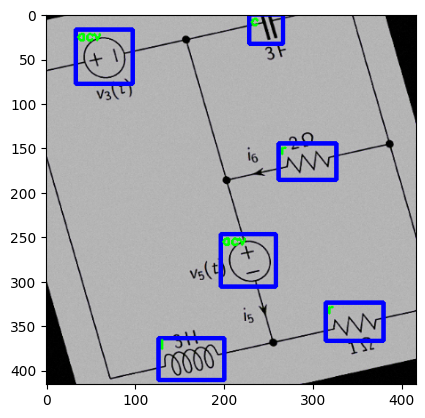

In [ ]:
batches = BatchGenerator(train_imgs, generator_config)
image = batches[0][0][0]
plt.imshow(image.astype('uint8'))

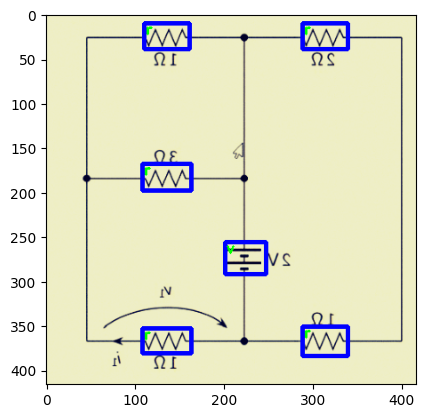

In [ ]:
batches = BatchGenerator(valid_imgs, generator_config)
image = batches[0][0][0]
plt.imshow(image.astype('uint8'))

In [ ]:
wt_path = 'yolov2.weights'

In [ ]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.compat.v1.space_to_depth(x, block_size=2)

In [ ]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
# Removed true_boxes as a separate Input layer

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(negative_slope=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(negative_slope=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2, output_shape=(13, 13, 256))(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(negative_slope=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# Removed the Lambda layer hack as true_boxes is no longer a model input

model = Model(input_image, output)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 416, 416,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 416, 416,  │        128 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 416, 416,  │          0 │ norm_1[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 208, 208,  │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 208, 208,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 208, 208,  │        256 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 208, 208,  │          0 │ norm_2[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 104, 104,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 104, 104,  │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_3              │ (None, 104, 104,  │        512 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 104, 104,  │          0 │ norm_3[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 104, 104,  │      8,192 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_4              │ (None, 104, 104,  │        256 │ conv_4[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 104, 104,  │          0 │ norm_4[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 104, 104,  │     73,728 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_5              │ (None, 104, 104,  │        512 │ conv_5[0][0]    

 Total params: 50,609,436 (193.06 MB)

 Trainable params: 50,588,764 (192.98 MB)

 Non-trainable params: 20,672 (80.75 KB)

In [ ]:
weight_reader = WeightReader(wt_path)

In [ ]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))

    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))

        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])

    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [ ]:
layer   = model.layers[-2] # the last convolutional layer
print(layer.name)
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

conv_23


In [ ]:
import keras.ops as ops

def custom_loss(combined_target, y_pred):
    # Using global LABELS and TRUE_BOX_BUFFER for consistent dimensions
    base_features_dim = 4 + 1 + len(LABELS)
    aux_features_dim = TRUE_BOX_BUFFER * 4

    # Split combined_target into y_true and true_boxes
    y_true = combined_target[..., :base_features_dim]
    # Extract true_boxes from the specific location it was stored (cell [0,0,0])
    true_boxes_flat = combined_target[:, 0, 0, 0, base_features_dim : base_features_dim + aux_features_dim]
    true_boxes = ops.reshape(true_boxes_flat, (-1, TRUE_BOX_BUFFER, 4)) # Reshape back to (BATCH_SIZE, TRUE_BOX_BUFFER, 4)

    mask_shape = ops.shape(y_true)[:4]

    cell_x = ops.cast(ops.reshape(ops.tile(ops.arange(GRID_W, dtype=tf.float32), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), dtype=tf.float32)
    cell_y = ops.transpose(cell_x, (0,2,1,3,4))

    cell_grid = ops.tile(ops.concatenate([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

    coord_mask = ops.zeros(mask_shape)
    conf_mask  = ops.zeros(mask_shape)
    class_mask = ops.zeros(mask_shape)

    # Removed tf.Variable for seen and total_recall as they cause issues in compiled Keras graph mode.
    # Warm-up logic depending on 'seen' will not function as originally intended within this loss function.
    # If warm-up is crucial, it should be managed via a Keras Callback or a custom training loop.

    """
    Adjust prediction
    """
    ### adjust x and y
    pred_box_xy = ops.sigmoid(y_pred[..., :2]) + cell_grid

    ### adjust w and h
    pred_box_wh = ops.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])

    ### adjust confidence
    pred_box_conf = ops.sigmoid(y_pred[..., 4])

    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]

    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell

    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically

    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half

    intersect_mins  = ops.maximum(pred_mins,  true_mins)
    intersect_maxes = ops.minimum(pred_maxes, true_maxes)
    intersect_wh    = ops.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = ops.divide(intersect_areas, union_areas)

    true_box_conf = iou_scores * y_true[..., 4]

    ### adjust class probabilities
    true_box_class = ops.argmax(y_true[..., 5:], -1)

    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = ops.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE

    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    # Expand true_boxes dimensions for broadcasting with pred_boxes for all-to-all IOU
    true_xy = ops.expand_dims(ops.expand_dims(ops.expand_dims(true_boxes[..., 0:2], 1), 1), 1)
    true_wh = ops.expand_dims(ops.expand_dims(ops.expand_dims(true_boxes[..., 2:4], 1), 1), 1)

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = ops.expand_dims(pred_box_xy, 4)
    pred_wh = ops.expand_dims(pred_box_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half

    intersect_mins  = ops.maximum(pred_mins,  true_mins)
    intersect_maxes = ops.minimum(pred_maxes, true_maxes)
    intersect_wh    = ops.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = ops.divide(intersect_areas, union_areas)

    best_ious = ops.max(iou_scores, axis=4)
    conf_mask = conf_mask + ops.cast(best_ious < 0.6, dtype=tf.float32) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE

    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE

    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * ops.take(CLASS_WEIGHTS, ops.cast(true_box_class, dtype=tf.int32)) * CLASS_SCALE

    """
    Warm-up training
    """
    # Removed warm-up logic based on `seen` tf.Variable due to KerasTensor compatibility issues in graph mode.
    # The warm-up modifications to true_box_xy, true_box_wh, coord_mask are now effectively bypassed.
    # If warm-up is needed, it should be managed via a Keras Callback.
    true_box_xy_final = true_box_xy
    true_box_wh_final = true_box_wh
    coord_mask_final = coord_mask

    """
    Finalize the loss
    """
    nb_coord_box = ops.sum(ops.cast(coord_mask_final > 0.0, dtype=tf.float32))
    nb_conf_box  = ops.sum(ops.cast(conf_mask  > 0.0, dtype=tf.float32))
    nb_class_box = ops.sum(ops.cast(class_mask > 0.0, dtype=tf.float32))

    loss_xy    = ops.sum(ops.square(true_box_xy_final-pred_box_xy)     * coord_mask_final) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = ops.sum(ops.square(true_box_wh_final-pred_box_wh)     * coord_mask_final) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = ops.sum(ops.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    # Using ops.sparse_categorical_crossentropy for class loss. true_box_class needs to be int32.
    loss_class = ops.sparse_categorical_crossentropy(target=ops.cast(true_box_class, dtype=tf.int32), output=pred_box_class, from_logits=True)
    loss_class = ops.sum(loss_class * class_mask) / (nb_class_box + 1e-6)

    loss = loss_xy + loss_wh + loss_conf + loss_class

    nb_true_box = ops.sum(y_true[..., 4])
    nb_pred_box = ops.sum(ops.cast(true_box_conf > 0.5, dtype=tf.float32) * ops.cast(pred_box_conf > 0.3, dtype=tf.float32))

    """
    Debugging code: tf.Print statements are removed as they are TF1 specific and can cause issues in TF2/Keras 3.
    Consider using tf.debugging.print_tensor in eager mode or standard print statements for debugging.
    """
    # Recall calculations removed as they relied on stateful tf.Variables
    # current_recall = nb_pred_box/(nb_true_box + 1e-6)
    # total_recall.assign_add(current_recall)

    return loss

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=3,
                           mode='min',
                           verbose=1)

weights_dir = "circuityolov2keras.weights.h5"
checkpoint = ModelCheckpoint(weights_dir,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')

In [ ]:
# tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'blood' in log]) + 1
# tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'blood' + '_' + str(tb_counter),
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=False)

optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#optimizer = SGD(learning_rate=1e-4, momentum=0.9)
#optimizer = RMSprop(learning_rate=1e-5, rho=0.9, epsilon=1e-08)

model.compile(loss=custom_loss, optimizer=optimizer)

In [ ]:
if not hasattr(np, 'bool'):
    np.bool = bool

In [ ]:
model.fit(train_batch,
          steps_per_epoch  = len(train_batch),
          epochs           = 10,
          verbose          = 1,
          validation_data  = valid_batch,
          validation_steps = len(valid_batch),
          callbacks        = [early_stop, checkpoint])

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 1.4132

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.28497, saving model to circuityolov2keras.weights.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 151s 617ms/step - loss: 1.4100 - val_loss: 0.2850
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 0.3546
Epoch 2: val_loss improved from 0.28497 to 0.20519, saving model to circuityolov2keras.weights.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 111s 665ms/step - loss: 0.3545 - val_loss: 0.2052
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 0.2589
Epoch 3: val_loss improved from 0.20519 to 0.16238, saving model to circuityolov2keras.weights.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 127s 763ms/step - loss: 0.2588 - val_loss: 0.1624
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 0.2042
Epoch 4: val_loss did not improve from 0.16238
166/166 ━━━━━━━━━━━━━━━━━━━━ 124s 602ms/step - loss: 0.2043 - val_loss: 0.1700
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 0.1953
Epoch 5: val_loss improved from 0.16238 to 0.14248, saving model to ci

In [ ]:
# # Access training and validation loss values from the history
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']

# # Plotting both training and validation loss
# epochs = range(1, len(training_loss) + 1)

# plt.plot(epochs, training_loss, label='Training Loss')
# plt.plot(epochs, validation_loss, label='Validation Loss')

# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
model.load_weights("circuityolov2keras.weights.h5")

In [ ]:
# model.evaluate(valid_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


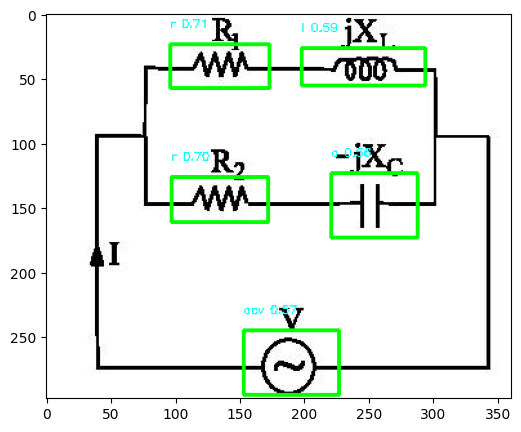

In [ ]:
image = cv2.imread("/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitioncoco/valid/electrical_197_png.rf.10209ef9d637420bf0cfd3a1a9df0650.jpg")

plt.figure(figsize=(6,6))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image])

boxes = decode_netout(netout[0],
                      obj_threshold=0.5,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS,
                      nb_class=CLASS)

LABELS = ["acv", "c", "i", "l", "r", "v"]
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


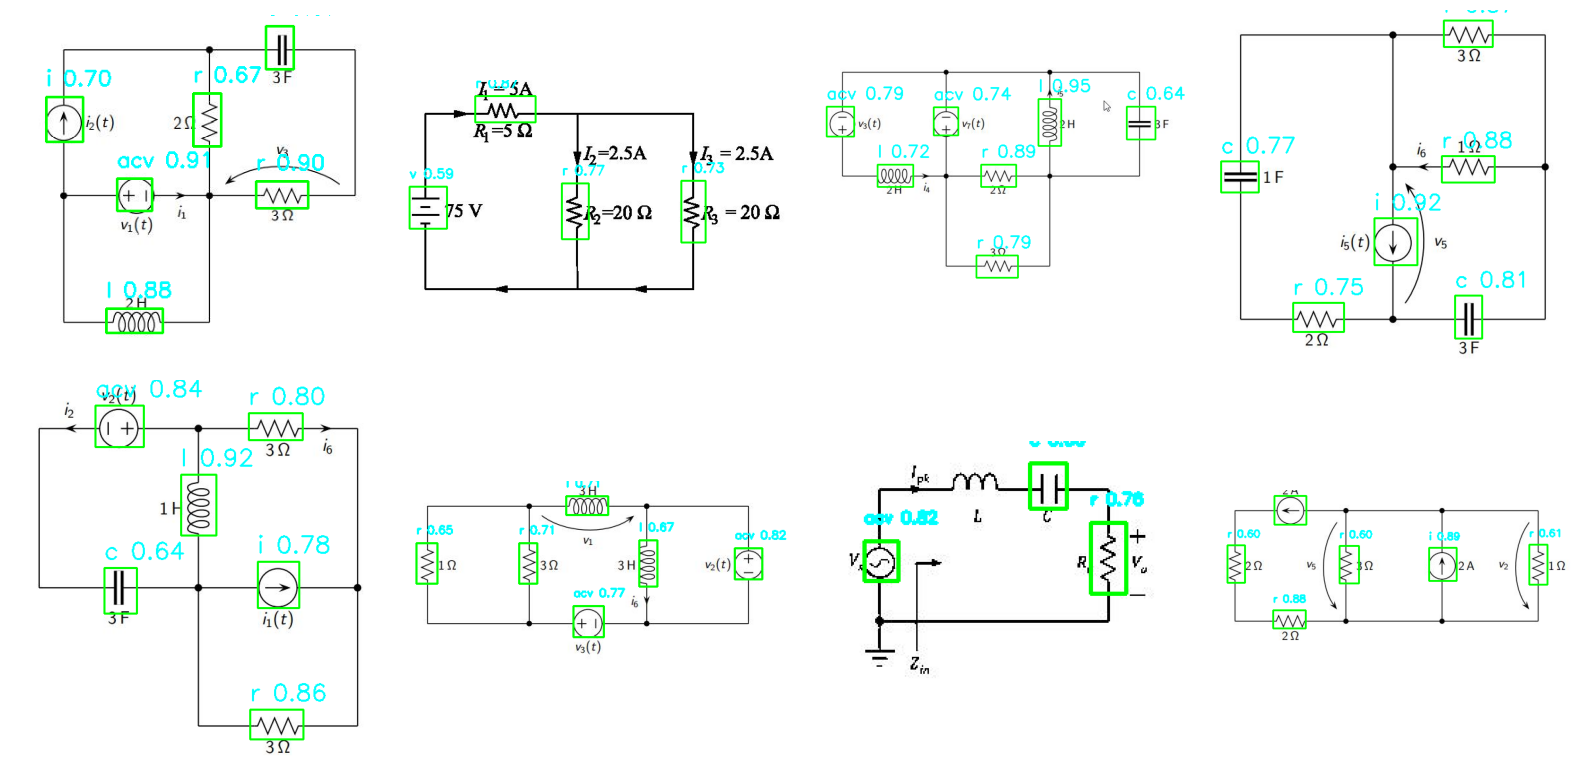

In [ ]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitioncoco/valid"

LABELS = ["acv", "c", "i", "l", "r", "v"]

# visualization layout
N = 8
cols = 4
rows = int(np.ceil(N / cols))

# ----------------------------------------

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

# load images
raw_images = []
orig_images = []

for p in sample_imgs:
    img = cv2.imread(p)
    orig_images.append(img.copy())
    raw_images.append(np.array(img))

plt.figure(figsize=(4 * cols, 4 * rows))

for i, image in enumerate(raw_images):
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image])

    boxes = decode_netout(netout[0],
                          obj_threshold=0.5,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS,
                          nb_class=CLASS)

    image = draw_boxes(image, boxes, labels=LABELS, fontsize=0.002, fontbold=2)

    # --- plot ---
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Serialize the model as a SavedModel.
# Use model.export for Keras models
model.export("circuityolov2keras")

# Convert to TFLite. This form of quantization is called
# post-training dynamic-range quantization in TFLite.
converter = tf.lite.TFLiteConverter.from_saved_model("circuityolov2keras")

# Enable TF Select ops for unsupported operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS # Enable TF Select ops
]

# No optimizations
tflite_model = converter.convert()
open("circuityolov2keras.tflite", "wb").write(tflite_model)

Saved artifact at 'circuityolov2keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name='keras_tensor_76')
Output Type:
  TensorSpec(shape=(None, 13, 13, 5, 12), dtype=tf.float32, name=None)
Captures:
  132875557416656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875557419536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132874457369104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875557417424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132875557418768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132874457369872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132874457367568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132874457366608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132874457367760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132874457368912: TensorSpec(shape=(), dtype=tf.resource, name=None)

202331404

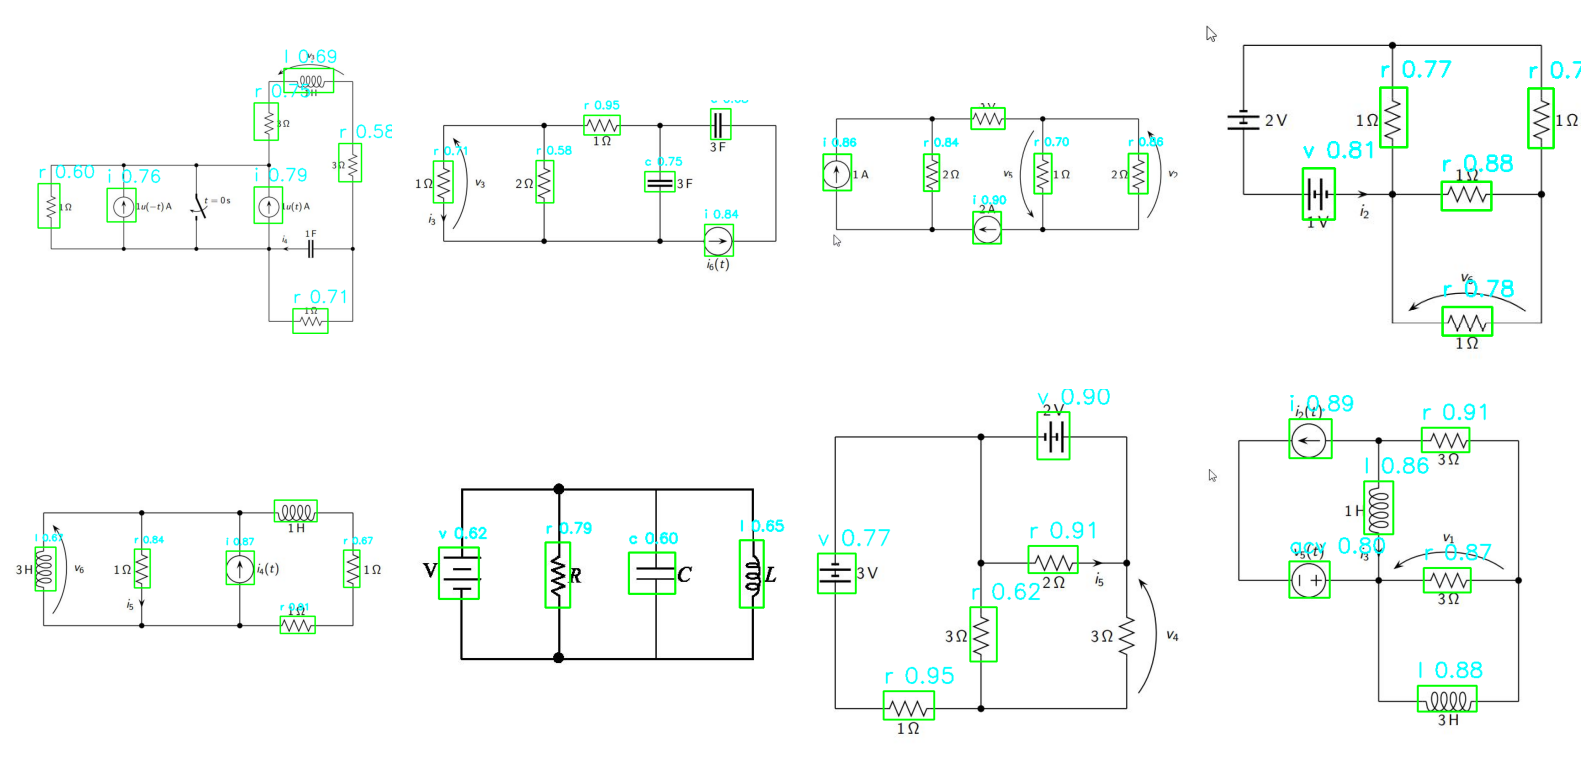

In [ ]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitioncoco/valid"

LABELS = ["acv", "c", "i", "l", "r", "v"]

# visualization layout
N = 8
cols = 4
rows = int(np.ceil(N / cols))

# ----------------------------------------

# ---- MODEL DIMENSIONS FOR TFLITE INFERENCE ----
MODEL_H = 416   # TFLite model input height
MODEL_W = 416   # TFLite model input width

# ---------- LOAD TFLITE ----------
interpreter = tf.lite.Interpreter(
    model_path="circuityolov2keras.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ---- FIX MODEL INPUT SHAPE (ONCE) ----
interpreter.resize_tensor_input(
    input_details[0]["index"],
    [1, MODEL_H, MODEL_W, 3],
    strict=True
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

# load images
raw_images = []
orig_images = []

for p in sample_imgs:
    img = cv2.imread(p)
    orig_images.append(img.copy())
    raw_images.append(np.array(img))

plt.figure(figsize=(4 * cols, 4 * rows))

for i, image in enumerate(raw_images):
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    input_data = (input_image).astype(np.float32)

    # set input
    interpreter.set_tensor(input_details[0]["index"], input_data)

    # run inference
    interpreter.invoke()

    # get outputs
    detections = interpreter.get_tensor(output_details[0]["index"])
    #print("raw outputs shape:", detections.shape)

    # netout = model.predict([input_image])
    # print("netout shape:", netout.shape)

    boxes = decode_netout(detections[0],
                          obj_threshold=0.5,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS,
                          nb_class=CLASS)

    image = draw_boxes(image, boxes, labels=LABELS, fontsize=0.002, fontbold=2)

    # --- plot ---
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install tf2onnx onnx onnxruntime

In [ ]:
import tensorflow as tf
import tf2onnx

# Load your model
# circuityolov2keras

# Give it a name if it’s Sequential (so ONNX export has clear I/O)
model._name = "circuityolov2keras"

# Define ONNX output path
onnx_model_path = "circuityolov2keras.onnx"

# Create a dummy input spec
spec = (tf.TensorSpec((None, 416, 416, 3), tf.float32, name="input"),)

# Convert model
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13,
    output_path=onnx_model_path
)

print(f"✅ Successfully converted to: {onnx_model_path}")

✅ Successfully converted to: circuityolov2keras.onnx


In [ ]:
import onnxruntime as ort
import numpy as np

session = ort.InferenceSession("circuityolov2keras.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

dummy_input = np.random.rand(1, 416, 416, 3).astype(np.float32)

outputs = session.run(None, {input_name: dummy_input})

print(len(outputs))
for o in outputs:
    print(o.shape)

1
(1, 13, 13, 5, 12)


onnx outputs shape: (1, 13, 13, 5, 12)
onnx outputs shape: (1, 13, 13, 5, 12)
onnx outputs shape: (1, 13, 13, 5, 12)
onnx outputs shape: (1, 13, 13, 5, 12)
onnx outputs shape: (1, 13, 13, 5, 12)
onnx outputs shape: (1, 13, 13, 5, 12)
onnx outputs shape: (1, 13, 13, 5, 12)
onnx outputs shape: (1, 13, 13, 5, 12)


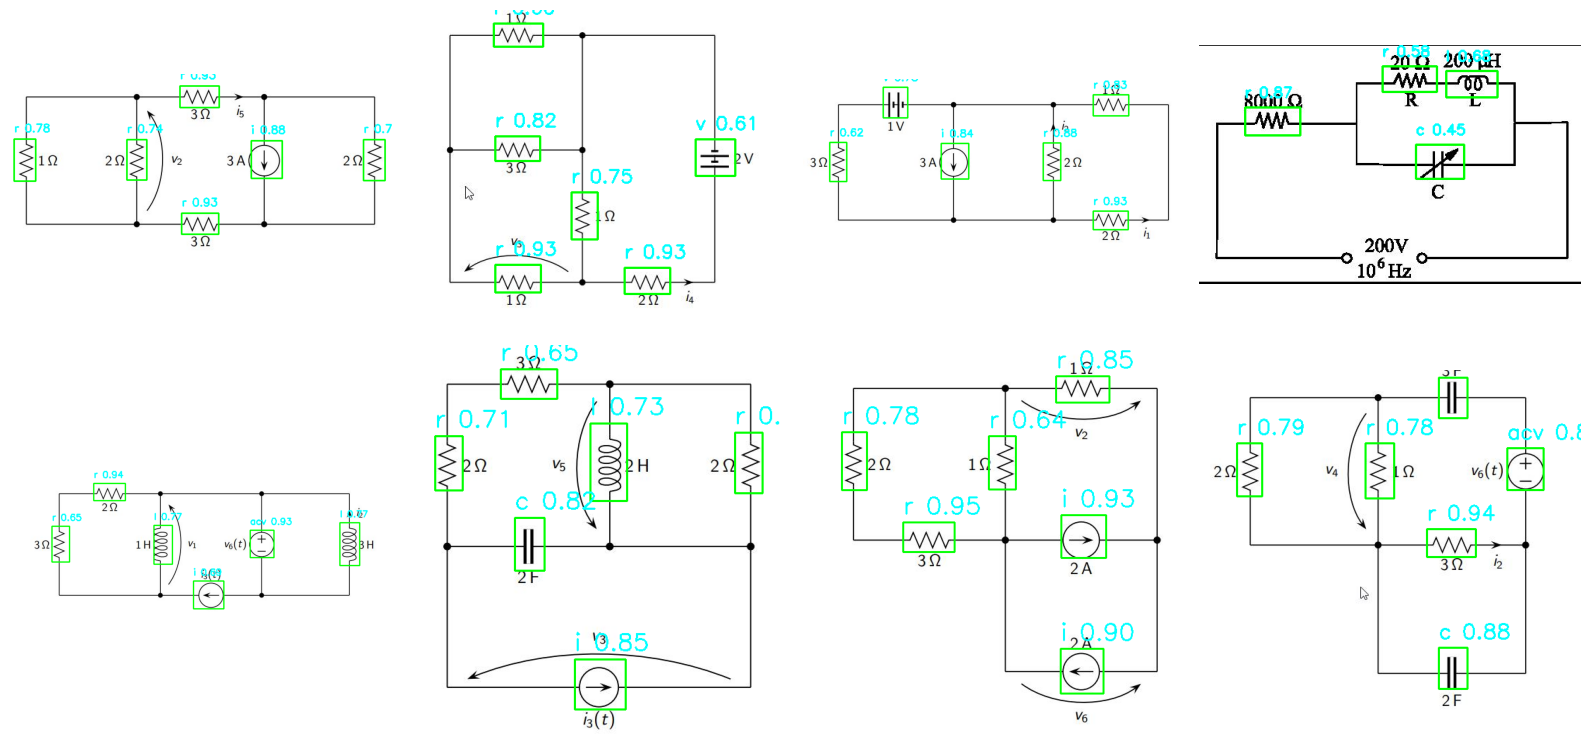

In [ ]:
import os, random, cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitioncoco/valid"

LABELS = ["acv", "c", "i", "l", "r", "v"]

# visualization layout
N = 8
cols = 4
rows = int(np.ceil(N / cols))

# ---------- LOAD ONNX ----------
session = ort.InferenceSession("circuityolov2keras.onnx")
input_name  = session.get_inputs()[0].name

output_names = [output.name for output in session.get_outputs()]

# ----------------------------------------

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

# load images
raw_images = []
orig_images = []

for p in sample_imgs:
    img = cv2.imread(p)
    orig_images.append(img.copy())
    raw_images.append(np.array(img))

plt.figure(figsize=(4 * cols, 4 * rows))

for i, image in enumerate(raw_images):
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    input_data = (input_image).astype(np.float32)

    # ---------- RUN ONNX INFERENCE ----------
    outputs = session.run(output_names, {input_name: input_data})
    outputs = np.squeeze(np.array(outputs), axis=0)
    print("onnx outputs shape:", outputs.shape)

    boxes = decode_netout(outputs[0],
                          obj_threshold=0.4,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS,
                          nb_class=CLASS)

    image = draw_boxes(image, boxes, labels=LABELS, fontsize=0.002, fontbold=2)

    # --- plot ---
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()